In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import arviz as az
import pymc as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cellbayesassay as cba
import os.path
import re
import warnings
import attila_utils

## Data import

The next codeblock was used to remove 'nm' (not measurable?) values during the data cleaning process.

In [2]:
data_fpath = '../../resources/cell-based-assays/NIA_NOG_tox-CO25360-v2-cleaned.xlsx'
data = cba.get_data(data_fpath, sheet_name='Sheet1', TI_fpath='../../resources/cell-based-assays/test-items3a-v2.csv')
data

,Study,Experiment,Assay,Batch,Plate,TI,Name,conc,concentration,conc_log10,Activity
0,CO25360,Aβ toxicity (primary neurons),MTT,1,1,TI1,Valproic acid,c1,0.00005,-4.30103,50.30000
1,CO25360,Aβ toxicity (primary neurons),MTT,1,1,TI1,Valproic acid,c1,0.00005,-4.30103,54.50000
2,CO25360,Aβ toxicity (primary neurons),MTT,1,1,TI1,Valproic acid,c1,0.00005,-4.30103,51.50000
3,CO25360,Aβ toxicity (primary neurons),MTT,1,1,TI1,Valproic acid,c1,0.00005,-4.30103,51.10000
4,CO25360,Aβ toxicity (primary neurons),MTT,1,1,TI1,Valproic acid,c1,0.00005,-4.30103,48.60000
...,...,...,...,...,...,...,...,...,...,...,...
2851,CO25360,Neurite outgrowth (primary neurons),Σ neurite area,3,4,TI27,TUDCA + fixed HCQ,c3,0.00001,-5.00000,74.86002
2852,CO25360,Neurite outgrowth (primary neurons),Σ neurite area,3,4,TI27,TUDCA + fixed HCQ,c3,0.00001,-5.00000,82.78183
2853,CO25360,Neurite outgrowth (primary neurons),Σ neurite area,3,4,TI27,TUDCA + fixed HCQ,c3,0.00001,-5.00000,63.04148
2854,CO25360,Neurite outgrowth (primary neurons),Σ neurite area,3,4,TI27,TUDCA + fixed HCQ,c3,0.00001,-5.00000,78.94833


## Check data

In [3]:
check_data = True
if check_data:
    testdf = cba.fit_multiple_units(data, unit_list=None, do_fit=False, do_print=False)
    print(testdf)

                                                                   study  \
CO25360 Aβ toxicity (primary neurons)       MTT            TI1   CO25360   
                                                           TI10  CO25360   
                                                           TI11  CO25360   
                                                           TI12  CO25360   
                                                           TI13  CO25360   
...                                                                  ...   
        Neurite outgrowth (primary neurons) Σ neurite area TI5   CO25360   
                                                           TI6   CO25360   
                                                           TI7   CO25360   
                                                           TI8   CO25360   
                                                           TI9   CO25360   

                                                                                       

## Fitting model

In [4]:
maindir = '../../results/2024-05-09-cell-bayes/'

if not os.path.exists(maindir + 'idatas/fpaths.csv'):
    idatadf = cba.fit_multiple_units(data, unit_list=None, accept_multi_batches=True)
    idatas = idatadf.idata
    fpathdf = cba.idatas_to_netcdf(idatas.dropna(), subdir='idatas/', maindir=maindir)
    print('idatas written to netcdf')
else:
    idatas = cba.idatas_from_netcdf(subdir='idatas/', maindir=maindir)
    print('idatas read from netcdf')

idatas = cba.sort_index_TI(idatas)
idatas

idatas read from netcdf


study    experiment                           assay           TI  
CO25360  Aβ toxicity (primary neurons)        MTT             TI1     (posterior, log_likelihood, sample_stats, obse...
                                                              TI2     (posterior, log_likelihood, sample_stats, obse...
                                                              TI3     (posterior, log_likelihood, sample_stats, obse...
                                                              TI4     (posterior, log_likelihood, sample_stats, obse...
                                                              TI5     (posterior, log_likelihood, sample_stats, obse...
                                                                                            ...                        
         Neurite outgrowth (primary neurons)  Σ neurite area  TI23    (posterior, log_likelihood, sample_stats, obse...
                                                              TI24    (posterior, log_likelih

## Fitted curves: posterior sample

In [5]:
plot_sampled_curves = False
fpath_suffix = '' if plot_sampled_curves else '-no-curves'

def assay_plotter(experiment, assay, plot_sampled_curves=plot_sampled_curves, compound_name_title=True):
    unit_list = idatas.loc(axis=0)[:, experiment, assay, :].index.to_numpy()
    fig, ax = cba.plot_multiple_units(unit_list, data, idatas, plot_sampled_curves=plot_sampled_curves, compound_name_title=compound_name_title)
    fig.suptitle(experiment + '\n' + assay)
    return((fig, ax))

for e, a in data[['Experiment', 'Assay']].apply(lambda x: (x.iloc[0], x.iloc[1]), axis=1).unique():
    print(e, a)

Aβ toxicity (primary neurons) MTT
Neurite outgrowth (primary neurons) branch points
Neurite outgrowth (primary neurons) longest neurite
Neurite outgrowth (primary neurons) neurogenesis
Neurite outgrowth (primary neurons) Σ neurite area


['named-figure/fitted-curves-Aβ-toxicity-primary-neurons-MTT-no-curves.png',
 'named-figure/fitted-curves-Aβ-toxicity-primary-neurons-MTT-no-curves.pdf']

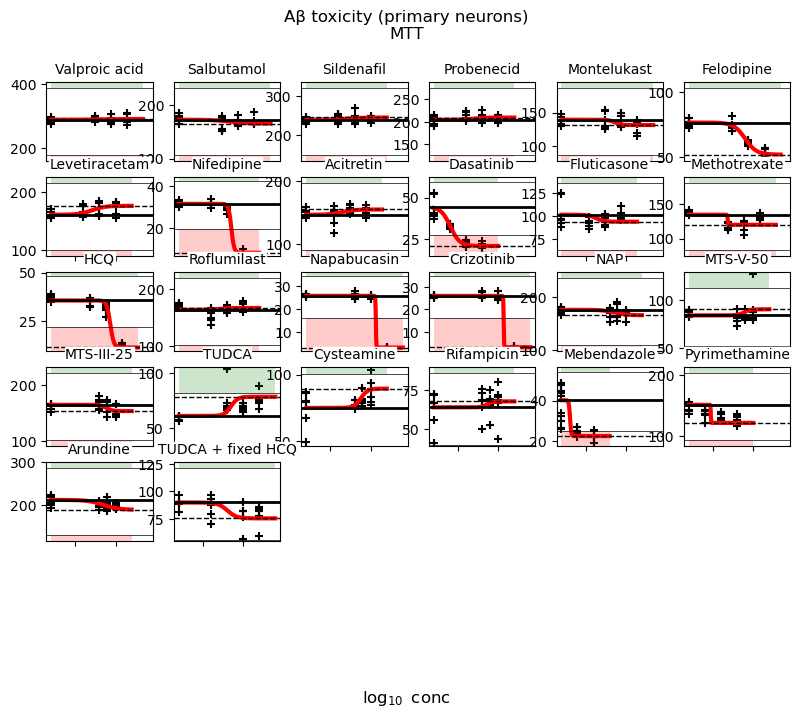

In [6]:
experiment = 'Aβ toxicity (primary neurons)'
assay = 'MTT'
fig, ax = assay_plotter(experiment, assay)
attila_utils.savefig(fig, 'fitted-curves-' + re.sub('[ ()]+', '-', experiment + ' ' + assay) + ('' if plot_sampled_curves else '-no-curves'))

['named-figure/fitted-curves-Neurite-outgrowth-primary-neurons-branch-points-no-curves.png',
 'named-figure/fitted-curves-Neurite-outgrowth-primary-neurons-branch-points-no-curves.pdf']

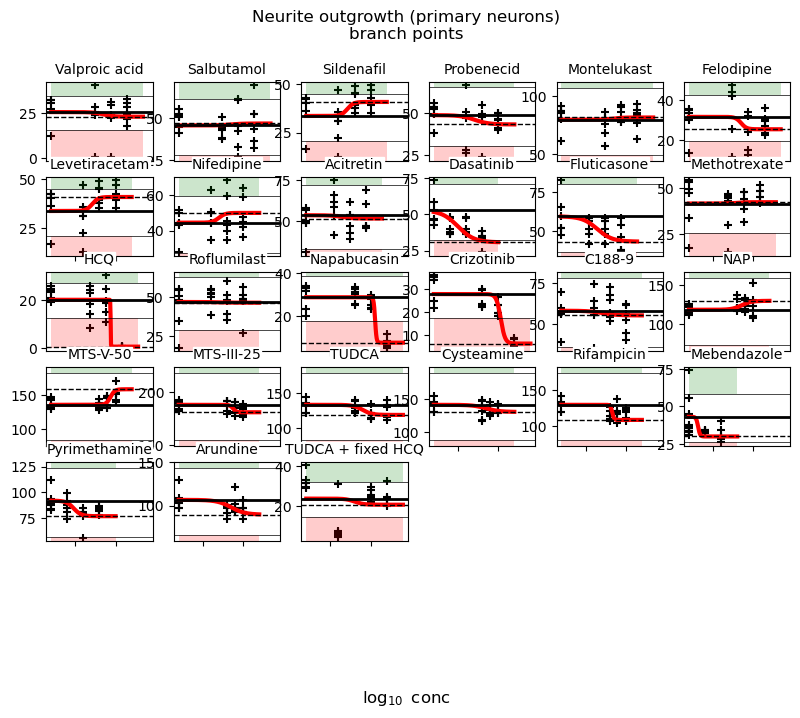

In [7]:
experiment = 'Neurite outgrowth (primary neurons)'
assay = 'branch points'
fig, ax = assay_plotter(experiment, assay)
attila_utils.savefig(fig, 'fitted-curves-' + re.sub('[ ()]+', '-', experiment + ' ' + assay) + ('' if plot_sampled_curves else '-no-curves'))

/Users/jonesa7/CTNS/notebooks/src/cellbayesassay.py:267: RuntimeWarning: overflow encountered in exp
  y_sigmoid_1_mean = y_1_mean + (y_0_mean - y_1_mean) / (1 + np.exp(k_mean * (xx - EC_50_mean)))


['named-figure/fitted-curves-Neurite-outgrowth-primary-neurons-longest-neurite-no-curves.png',
 'named-figure/fitted-curves-Neurite-outgrowth-primary-neurons-longest-neurite-no-curves.pdf']

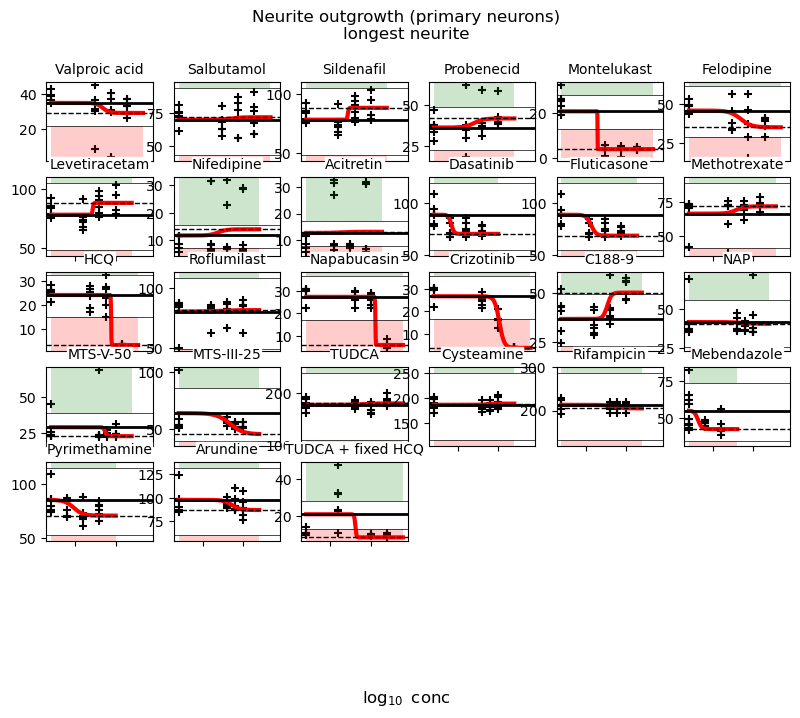

In [8]:
experiment = 'Neurite outgrowth (primary neurons)'
assay = 'longest neurite'
fig, ax = assay_plotter(experiment, assay)
attila_utils.savefig(fig, 'fitted-curves-' + re.sub('[ ()]+', '-', experiment + ' ' + assay) + ('' if plot_sampled_curves else '-no-curves'))

/Users/jonesa7/CTNS/notebooks/src/cellbayesassay.py:267: RuntimeWarning: overflow encountered in exp
  y_sigmoid_1_mean = y_1_mean + (y_0_mean - y_1_mean) / (1 + np.exp(k_mean * (xx - EC_50_mean)))
/Users/jonesa7/CTNS/notebooks/src/cellbayesassay.py:267: RuntimeWarning: overflow encountered in exp
  y_sigmoid_1_mean = y_1_mean + (y_0_mean - y_1_mean) / (1 + np.exp(k_mean * (xx - EC_50_mean)))


['named-figure/fitted-curves-Neurite-outgrowth-primary-neurons-neurogenesis-no-curves.png',
 'named-figure/fitted-curves-Neurite-outgrowth-primary-neurons-neurogenesis-no-curves.pdf']

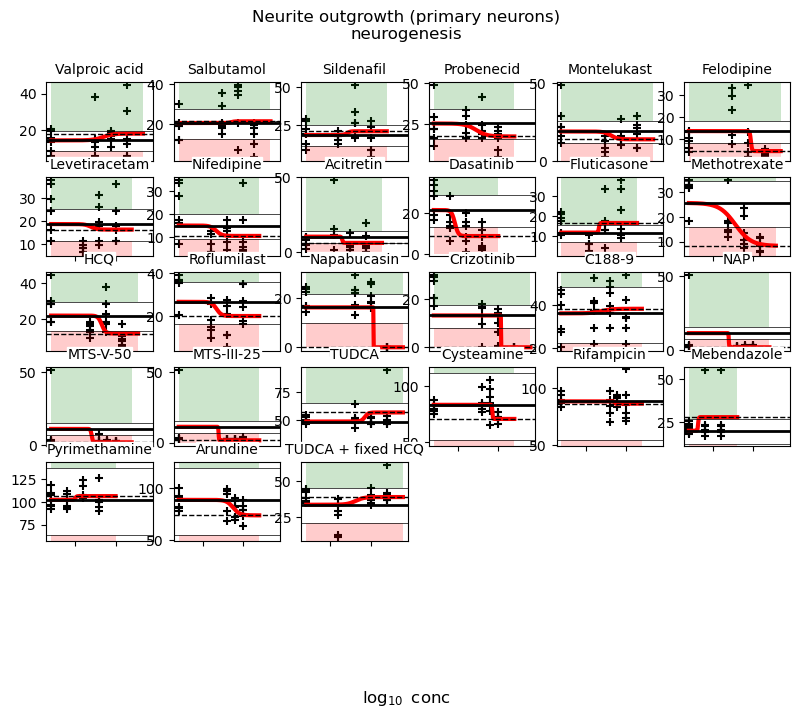

In [9]:
experiment = 'Neurite outgrowth (primary neurons)'
assay = 'neurogenesis'
fig, ax = assay_plotter(experiment, assay)
attila_utils.savefig(fig, 'fitted-curves-' + re.sub('[ ()]+', '-', experiment + ' ' + assay) + ('' if plot_sampled_curves else '-no-curves'))

/Users/jonesa7/CTNS/notebooks/src/cellbayesassay.py:267: RuntimeWarning: overflow encountered in exp
  y_sigmoid_1_mean = y_1_mean + (y_0_mean - y_1_mean) / (1 + np.exp(k_mean * (xx - EC_50_mean)))


['named-figure/fitted-curves-Neurite-outgrowth-primary-neurons-Σ-neurite-area-no-curves.png',
 'named-figure/fitted-curves-Neurite-outgrowth-primary-neurons-Σ-neurite-area-no-curves.pdf']

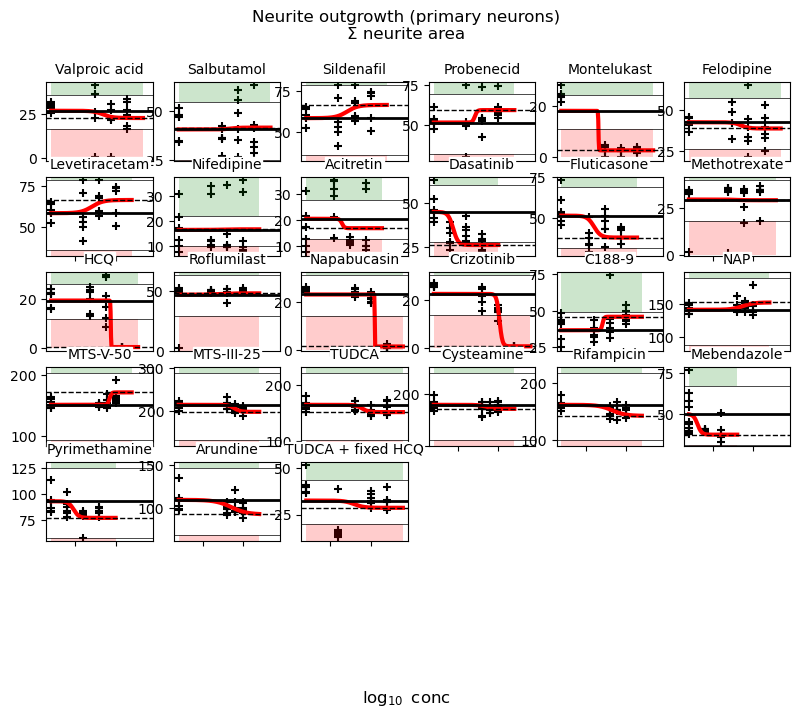

In [10]:
experiment = 'Neurite outgrowth (primary neurons)'
assay = 'Σ neurite area'
fig, ax = assay_plotter(experiment, assay)
attila_utils.savefig(fig, 'fitted-curves-' + re.sub('[ ()]+', '-', experiment + ' ' + assay) + ('' if plot_sampled_curves else '-no-curves'))

## MCMC diagnostics

In [11]:
cba.get_diagnostics_series(idatas, az.ess)

In [12]:
cba.get_diagnostics_series(idatas, az.rhat, vmax=1.1)

In [13]:
df = cba.get_diagnostics_series(idatas, az.mcse, return_df=True).drop('k', level='parameter', axis=0)
df.style.format(precision=3).background_gradient(axis=None, vmin=df.min().min(), vmax=df.max().max(), cmap='hot')

['named-figure/ess.png', 'named-figure/ess.pdf']

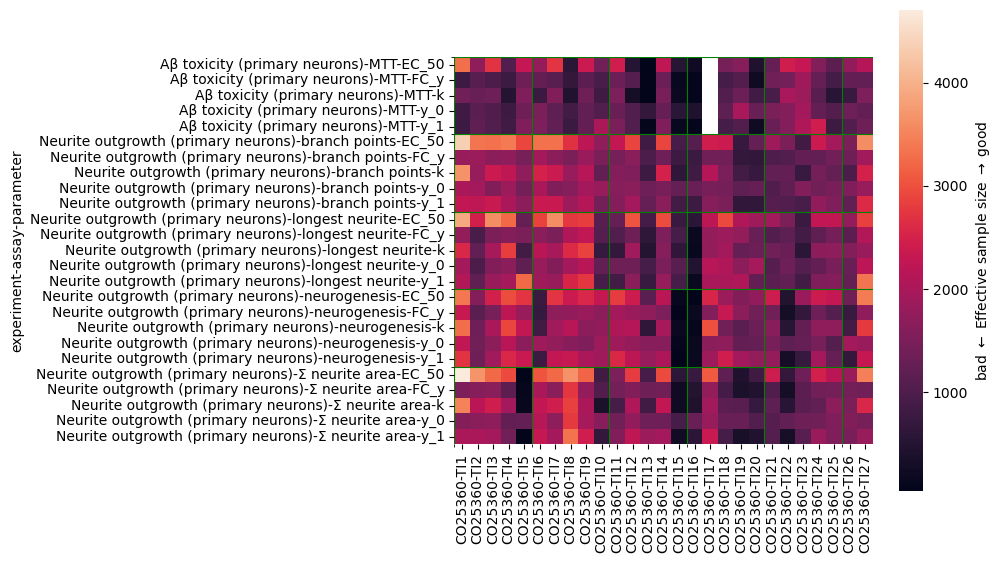

In [14]:
g = cba.diagnostics_series_heatmap(idatas, az.ess, yticklabels=True)
attila_utils.savefig(g.figure, 'ess')

['named-figure/rhat.png', 'named-figure/rhat.pdf']

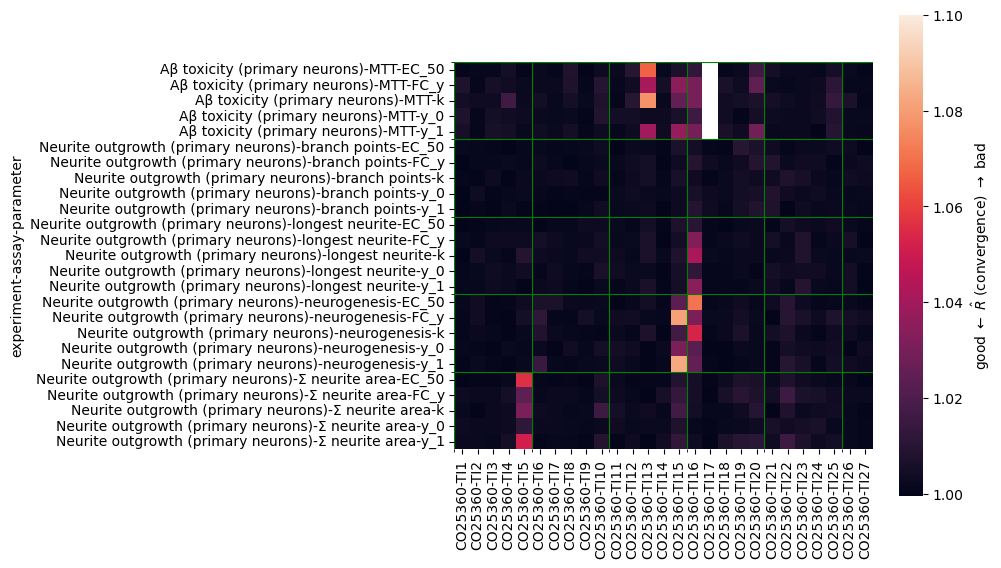

In [15]:
g = cba.diagnostics_series_heatmap(idatas, az.rhat, yticklabels=True, vmax=1.1)
attila_utils.savefig(g.figure, 'rhat')

['named-figure/mcse.png', 'named-figure/mcse.pdf']

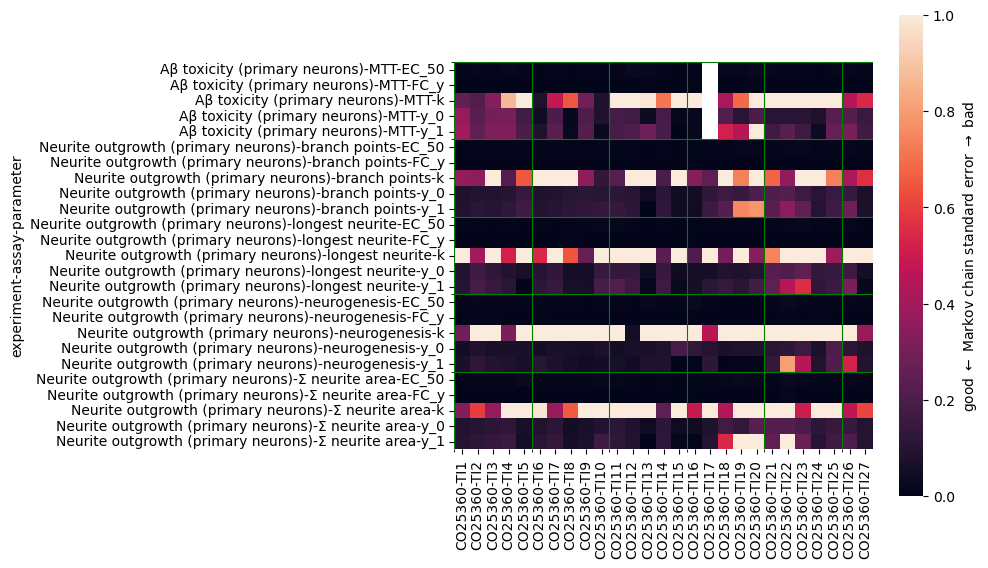

In [16]:
g = cba.diagnostics_series_heatmap(idatas, az.mcse, yticklabels=True, vmax=1)
attila_utils.savefig(g.figure, 'mcse')

In [17]:
poor_fits = [
    ('CO25360', 'Neurite outgrowth (primary neurons)', 'longest neurite', 'TI5'),
    ('CO25360', 'Neurite outgrowth (primary neurons)', 'Σ neurite area', 'TI5'),
    ('CO25360', 'Neurite outgrowth (primary neurons)', 'neurogenesis', 'TI18'),
]


In [18]:
fpath = '../../results/2024-05-09-cell-bayes/H102_posteriors.csv'
if not os.path.exists(fpath):
    H102_posteriors = cba.get_H102_posterior_from_idatas(idatas, poor_fits)
    H102_posteriors = cba.sort_index_TI(H102_posteriors)
    df = cba.get_TI_name('/Users/jonesa7/CTNS/resources/cell-based-assays/test-items3a-v2.csv')
    H102_posteriors['name'] = df.loc[H102_posteriors.index.to_frame().apply(lambda r: (r.loc['study'], r.loc['TI']), axis=1), 'Name'].to_list()
    H102_posteriors.to_csv(fpath)
else:
    H102_posteriors = pd.read_csv(fpath, index_col=[0, 1, 2, 3])
    
H102_posteriors

H1  \
study   experiment                          assay          TI              
CO25360 Aβ toxicity (primary neurons)       MTT            TI1   0.00025   
                                                           TI2   0.00375   
                                                           TI3   0.00125   
                                                           TI4   0.00225   
                                                           TI5   0.00200   
...                                                                  ...   
        Neurite outgrowth (primary neurons) Σ neurite area TI23  0.00000   
                                                           TI24  0.00175   
                                                           TI25  0.00000   
                                                           TI26  0.00050   
                                                           TI27  0.02650   

                                                                      H0  \
study   experiment                          assay          TI              
CO25360 Aβ toxicity (primary neurons)       MTT            TI1   0.99975   
                                                           TI2   0.99625   
                                                           TI3   0.99875   
                                                           TI4   0.99775   
                                                           TI5   0.99725   
...                                                                  ...   
        Neurite outgrowth (primary neurons) Σ neurite area TI23  0.99550   
                                                           TI24  0.87600   
                                                           TI25  0.96875   
                                                           TI26  0.98050   
                                                           TI27  0.91500   

                                                                      H2  \
study   experiment                          assay          TI              
CO25360 Aβ toxicity (primary neurons)       MTT            TI1   0.00000   
                                                           TI2   0.00000   
                                                           TI3   0.00000   
                                                           TI4   0.00000   
                                                           TI5   0.00075   
...                                                                  ...   
        Neurite outgrowth (primary neurons) Σ neurite area TI23  0.00450   
                                                           TI24  0.12225   
                                                           TI25  0.03125   
                                                           TI26  0.01900   
                                                           TI27  0.05850   

                                                                              name  
study   experiment                          assay          TI                       
CO25360 Aβ toxicity (primary neurons)       MTT            TI1       Valproic acid  
                                                           TI2          Salbutamol  
                                                           TI3          Sildenafil  
                                                           TI4          Probenecid  
                                                           TI5         Montelukast  
...                                                                            ...  
        Neurite outgrowth (primary neurons) Σ neurite area TI23         Rifampicin  
                                                           TI24        Mebendazole  
                                                           TI25      Pyrimethamine  
                                                           TI26           Arundine  
                                                           TI27  TUDCA + fixed HCQ 

In [19]:
%connect_info

{
  "shell_port": 59351,
  "iopub_port": 59352,
  "stdin_port": 59353,
  "control_port": 59355,
  "hb_port": 59354,
  "ip": "127.0.0.1",
  "key": "4c9efef8-7f231f08514e9a6166c6598a",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": "python3",
  "jupyter_session": "/Users/jonesa7/CTNS/notebooks/2024-05-09-cell-bayes/2024-05-09-cell-bayes.ipynb"
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-a8cad2e0-e849-4963-bef1-b63968e1e0b9.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
